In [13]:
from sklearn.svm import SVC
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

In [14]:
os.chdir('../data')


X = pd.read_csv('X_3specialties_equalWeight_subsample.zip',compression='zip', index_col=False)
y = pd.read_csv('y_3specialties_equalWeight_subsample.zip',compression='zip')
groups = pd.read_csv('groups_3specialties_equalWeight_subsample.zip',compression='zip')

X = X.iloc[:,1:]
y = y.iloc[:,1:]
groups = groups.iloc[:,1:]

y_columns = y.columns

#le = LabelEncoder()
#y = y.values.ravel()
#y = le.fit_transform(y)
#y = pd.DataFrame(y)
#y.columns = y_columns

In [80]:
def ML_RFpipeline_kfold(X, y, groups, random_state,n_folds):
    # create a test set
    
    splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
    
    for i_other,i_test in splitter.split(X, y, groups):
        X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
        
    kf = GroupKFold(n_splits=n_folds)
    
    # create the pipeline: preprocessor + supervised ML method
    
    categorical_ftrs = ['Prscrbr_City','Prscrbr_State_Abrvtn','Brnd_Name','Gnrc_Name']

    std_ftrs = ['Tot_Clms',  'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 
                'Tot_Benes', 'GE65_Tot_Clms', 'GE65_Tot_30day_Fills', 'GE65_Tot_Drug_Cst',
                'GE65_Tot_Day_Suply', 'GE65_Tot_Benes']
    
    std_ftrs = ['Tot_Clms', 
            'Tot_30day_Fills', 
            'Tot_Day_Suply', 
            'Tot_Drug_Cst', 
            'Tot_Benes', 
            'GE65_Tot_Clms',
            'GE65_Tot_30day_Fills',
            'GE65_Tot_Drug_Cst',
            'GE65_Tot_Day_Suply',
            'GE65_Tot_Benes']
    
    numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator = LinearRegression(), 
                                    random_state=random_state,max_iter=1000)),
    ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    
    final_scaler = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, std_ftrs),
        ('onehot', categorical_transformer, categorical_ftrs)],
        remainder='passthrough')



    # the parameter(s) we want to tune

    
    param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100], #
                  'svc__gamma': [0.01, 0.1, 1, 10, 100],
                  'svc__random_state':[random_state]}  #
    
    pipe = make_pipeline(preprocessor, final_scaler, SVC(kernel='linear'))
    
    
    #f05_scorer = make_scorer(fbeta_score, beta=0.5, average = 'macro')
    # prepare gridsearch
    grid = GridSearchCV(pipe, 
                        param_grid=param_grid,
                        scoring = 'accuracy',
                        cv=kf, 
                        return_train_score = True, 
                        n_jobs=8,
                        verbose=10)
    
    # do kfold CV on _other
    
    grid_result = grid.fit(X_other, y_other.values.ravel(), groups=groups_other)
    
    feature_names = std_ftrs + list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(categorical_ftrs))
    
    print()
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    
    print(f'Best params: {grid.best_params_}')
    
    print(f"mean CV: {means} +/ {stds}")
    
    #y_test_pred_proba = grid.predict_proba(X_test)
    
    y_test_pred = grid.predict(X_test)
    
    #score = accuracy_score(y_test,y_test_pred)
    
    f_05_score = fbeta_score(y_test, y_test_pred, beta = 0.5, labels=sorted(np.unique(y)), average='macro')
    
    cm = confusion_matrix(y_test, y_test_pred)
    
    
    accuracy = accuracy_score(y_test, y_test_pred)
    print("accuracy:", accuracy)
    
    print("f05:", f_05_score)
    print()
    return grid, X_test, y_test, f_05_score, cm, accuracy, feature_names

In [81]:
%%time
final_models_list = []
test_scores = []
best_params = []
confusion_mat = []
class_met = []
accuracy_scores = []
final_models = []
X_test_set_list =[]
y_test_set_list =[]
featname_list = []

for i in range(5):
    print(f'Random State # {i}')
    print()
    
    fin_grid, X_test_set, y_test_set, test_score, cmat, accuracy, feature_names = ML_RFpipeline_kfold(X, y, groups, 42*i , 4)
    
    #featname_list.append(featname)
    
    X_test_set_list.append(X_test_set)
    
    y_test_set_list.append(y_test_set)
    
    final_models_list.append(fin_grid)
    
    test_scores.append(test_score)
    
    confusion_mat.append(cmat)

    accuracy_scores.append(accuracy)
    
    featname_list.append(feature_names)

Random State # 0

Fitting 4 folds for each of 25 candidates, totalling 100 fits

Best params: {'svc__C': 0.01, 'svc__gamma': 0.01, 'svc__random_state': 0}
mean CV: [0.78228154 0.78228154 0.78228154 0.78228154 0.78228154 0.75939897
 0.75939897 0.75939897 0.75939897 0.75939897 0.75201734 0.75201734
 0.75201734 0.75201734 0.75201734 0.72591164 0.72591164 0.72591164
 0.72591164 0.72591164 0.70832479 0.70832479 0.70832479 0.70832479
 0.70832479] +/ [0.06812193 0.06812193 0.06812193 0.06812193 0.06812193 0.0757369
 0.0757369  0.0757369  0.0757369  0.0757369  0.05937946 0.05937946
 0.05937946 0.05937946 0.05937946 0.06202274 0.06202274 0.06202274
 0.06202274 0.06202274 0.05053916 0.05053916 0.05053916 0.05053916
 0.05053916]
accuracy: 0.8955752212389381
f05: 0.8752842873153358

Random State # 1

Fitting 4 folds for each of 25 candidates, totalling 100 fits

Best params: {'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__random_state': 42}
mean CV: [0.76692913 0.76692913 0.76692913 0.76692913 0.7669291

In [93]:
confusion_mat

[array([[323,  49,   8],
        [ 40, 203,   2],
        [  9,  10, 486]], dtype=int64),
 array([[259, 175,   4],
        [133, 288,   9],
        [ 38,  31, 400]], dtype=int64),
 array([[148, 137,   1],
        [140, 273,  39],
        [  8,   7, 493]], dtype=int64),
 array([[414, 104,  88],
        [ 57, 283,   2],
        [  8,  56, 445]], dtype=int64),
 array([[231,  68,   5],
        [210, 202,  72],
        [  8,  17, 349]], dtype=int64)]

In [92]:
# save the output so I can use it later
import pickle

file = open('SVC_grid.save', 'wb')

pickle.dump((X_test_set_list, 
             y_test_set_list,
             final_models_list,
             test_scores,
             confusion_mat,
             accuracy_scores,
             featname_list),file)

file.close()

### SVC Feature Importance (Coefficient)

In [50]:
file = open('SVC_grid.save', 'rb')
X_test, y_test, model, f05, confusionmatrix, accuracy, ftr_names = pickle.load(file)
file.close()


In [51]:
X_test = X_test[0]
y_test = y_test[0]
grid = model[0]
f05 = f05[0]
confusionmatrix = confusionmatrix[0]
accuracy  = accuracy[0]
ftr_names  = ftr_names[0]

In [53]:
feature_importances_SVC = grid.best_estimator_[2].coef_

len(feature_importances_SVC)

3

In [56]:
len(feature_importances_SVC[0])

1081

In [ ]:
grid.best_estimator_[1].feature_importances_

In [62]:
grid.best_estimator_[2]

SVC(C=0.01, gamma=0.01, kernel='linear', random_state=0)

In [70]:
ftr_names

['Tot_Clms',
 'Tot_30day_Fills',
 'Tot_Day_Suply',
 'Tot_Drug_Cst',
 'Tot_Benes',
 'GE65_Tot_Clms',
 'GE65_Tot_30day_Fills',
 'GE65_Tot_Drug_Cst',
 'GE65_Tot_Day_Suply',
 'GE65_Tot_Benes',
 'Prscrbr_City_Abilene',
 'Prscrbr_City_Aguadilla',
 'Prscrbr_City_Alexandria',
 'Prscrbr_City_Alhambra',
 'Prscrbr_City_Amityville',
 'Prscrbr_City_Ann Arbor',
 'Prscrbr_City_Antioch',
 'Prscrbr_City_Arcadia',
 'Prscrbr_City_Arlington',
 'Prscrbr_City_Asheville',
 'Prscrbr_City_Athens',
 'Prscrbr_City_Bakersfield',
 'Prscrbr_City_Baltimore',
 'Prscrbr_City_Baton Rouge',
 'Prscrbr_City_Beachwood',
 'Prscrbr_City_Bellevue',
 'Prscrbr_City_Berkeley',
 'Prscrbr_City_Birmingham',
 'Prscrbr_City_Boston',
 'Prscrbr_City_Boynton Beach',
 'Prscrbr_City_Burlington',
 'Prscrbr_City_Cambridge',
 'Prscrbr_City_Cedar Rapids',
 'Prscrbr_City_Chambersburg',
 'Prscrbr_City_Charlotte',
 'Prscrbr_City_Chelmsford',
 'Prscrbr_City_Cherry Hill',
 'Prscrbr_City_Chicago',
 'Prscrbr_City_Cleveland',
 'Prscrbr_City_Columbia'

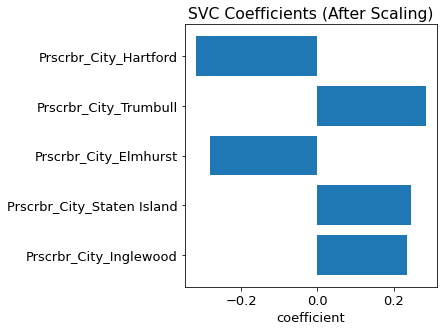

In [77]:
coefs =grid.best_estimator_[2].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))
ftr_names = np.array(ftr_names)

plt.figure(figsize=(6.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(5),coefs[sorted_indcs[-5:]])
plt.yticks(np.arange(5),ftr_names[sorted_indcs[-5:]])
plt.xlabel('coefficient')
plt.title('SVC Coefficients (After Scaling)')
plt.tight_layout()
plt.savefig('SVC_coefs_scaled.png',dpi=300)
plt.show()

### Permutation Feature Importance

In [91]:

# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
r_list = []
print(np.shape(X_test_transformed))


from sklearn.inspection import permutation_importance

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in range(5):
        r = permutation_importance(grid.best_estimator_[2], X_test_transformed, y_test,
                               n_repeats=30, random_state=42*i,scoring = 'accuracy')
    
        r_list.append(r)

(1130, 1081)


In [ ]:
featnames = []
feat_importances_mean = []
feat_std = []


for i in r.importances_mean.argsort()[-5:][::-1]:
    featnames.append(ftr_names[i])
    feat_importances_mean.append(r.importances_mean[i])
    feat_std.append(r.importances_std[i])
    
    
    print(f"{ftr_names[i]:}: {r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

In [65]:
file = open('SVC_PFI.save', 'wb')

pickle.dump((r),file)

file.close()